# Der Funkkanal
Dieses Notebook dient als Theorie-Verständnisübung für Überlegungen zum allgemeinen Funkkanal. Die Annahmen und Formeln beruhen, soweit nicht weiter kenntlich gemacht, auf [Kammeyer, 2004](https://link.springer.com/book/10.1007/978-3-322-94062-9). 
________
Als aller erstes soll hierzu der **AWGN Kanal für ein SISO System** untersucht werden. Am einfachsten ist hier zuerst die Untersuchung hinsichtlich der Bitfehlerwarscheinlichkeit, da diese mit vielen Beispielen (u.a. Matlab MKS) hinreichend dokumentiert ist. Kammeyer beschreibt die Formel

\begin{equation}
\tag{15.2.2}
P_b = K \cdot erfc \left ( \sqrt{\frac{E_b}{N_0} \gamma^2} \right )
\end{equation}

wobei $K$ und $\gamma^2$ jeweils durch die jeweiligen Modulationsformate gegeben sind (siehe Tabelle Seite 563). Wichtiger ist hierbei festzustellen, dass wir ebenfalls von $\frac{E_b}{N_0}$ und $\frac{E_S}{N_0}$ sprechen - also Energie _pro bit_ bzw. _pro Symbol_ durch _Rauschleistung pro 1 Hz_. Dieses ist wichtig, da wir das SNR standardmäßig pro bit addressieren, die Funktion _set_snr_ aus der comm-Bibliothek allerdings SNR pro Symbol erwartet. Eine Umrechnung von (linearem) SNR zu $\frac{E_S}{N_0}$ kann erfolgen, indem man das SNR auf $E_S$ skaliert, indem man das gewünschte SNR mit der Anzahl der bits pro Symbol multipliziert. 

\begin{equation}
\tag{--}
\frac{E_S}{N_0} = SNR_{lin} \cdot log2(M)
\end{equation}

wobei $M$ Im folgenden soll im Bereich von 0-40dB SNR die Bitfehlerwarscheinlichleit für eine QPSK über den AWGN-Kanal untersucht werden. Für QPSK gilt $K = 1/2$ und $\gamma^2 = 1$.


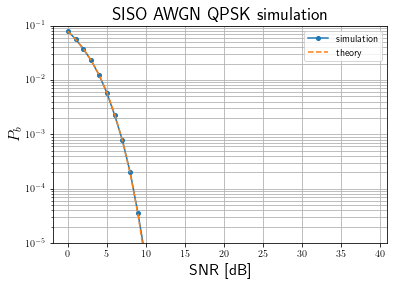

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import comm as comm
import copy
from scipy import special

plt.rcParams['text.usetex'] = True

#setting some parameters
n_symbols = 5e5
format_transmission = "PSK"
order = 4
Nr = 1

#generating some placeholders
snr_list = np.arange(0,40)
EsNo = 10**(snr_list/10)*np.log2(order) #skalierung von SNR auf SNR pro Symbol
EbNo = EsNo/np.log2(order) #skalierung von SNR pro Symbol auf SNR pro Bit
ber_res = np.ones(snr_list.shape)

for k in range(len(snr_list)):
    
    #generating signal object
    sig_tx = comm.signal.Signal(n_dims=Nr)
    sig_tx.generate_bits(n_bits=int(n_symbols*np.log2(order)),seed=None)
    sig_tx.generate_constellation(format=format_transmission, order=order)
    sig_tx.mapper()
    sig_tx.pulseshaper(upsampling=1, pulseshape="None") #we need this here, because of copying stuff in comm
    
    #### Channel ###################
    sig_ch = copy.deepcopy(sig_tx)
    sig_ch.samples[0] = comm.channel.set_snr(sig_ch.samples[0], snr_dB=10*np.log10(EsNo[k]))

    sig_rx = copy.deepcopy(sig_ch)

    sig_rx.decision()
    sig_rx.demapper()
    
    ber_res[k] = comm.rx.count_errors(sig_rx.bits[0], sig_rx.samples[0])["ber"]

awgn_theory_qpsk = 1/2 * special.erfc(np.sqrt(EbNo*1**2))   

plt.title("SISO AWGN QPSK simulation", fontsize=18)
plt.semilogy(snr_list, ber_res, marker="o", markersize=4, label="simulation")
plt.semilogy(snr_list, awgn_theory_qpsk, ls="--", label="theory")
plt.xlabel("SNR [dB]", fontsize=16)
plt.ylabel(r"$P_b$", fontsize=16)
plt.legend()
plt.ylim(1e-5,1e-1)
plt.grid(visible=True, which="both")
plt.show()

_______
Da die Funkkanal-Theorie insbesondere unter Betrachtung des Mobilfunkkanals Anwendung findet, werden insbesondere Beispiele aus diesem Bereich innerhalb der Literatur behandelt. Ein ebenfalls sehr prominentes Beispiel stellt dabei ein **SISO-System mit Rayleigh-Fading** dar. Dieses Kanalmodell beschreibt den Umstand, dass die Übertragung nur NLOS Signalelemente und keine LOS Signalelemente enthält. Dieses soll im folgenden untersucht werden. 
Das Empfangssignal eines Rayleigh-Funkkanals kann definiert werden als 

\begin{equation}
\tag{15.2.1}
r(t) = A \cdot e^{j\psi_0} s(t) + n(t)
\end{equation}

wobei $A$ eine Zufallsvariable mit Rayleigh-Verteilung darstellt, und sich somit der komplexe Kanalfaktor $A \cdot  e^{j\psi_0}$ ergibt. Dieses gilt, solange angenommen werden kann, dass der Phasenfehler $\psi_0$ im kohärenten System ideal kompensiert wird, und sich somit zu 0 ergbit. Kammeyer errechnet aus der Formel 15.2.2 mithilfe der Rayleigh-Verteilung eine für einen Rayleigh-Kanal angenomme Formel der [ergodischen](https://de.wikipedia.org/wiki/Ergodizität#Allgemeines) Bitfehlerwarscheinlichkeit 

\begin{equation}
\tag{15.2.10}
\bar{P_b}^{Ray} = K \cdot \left ( 1 - \sqrt{\frac{\gamma^2 \bar{E_b}/N_0}{ 1 - \gamma^2 \bar{E_b}/N_0}} \right )
\end{equation}

die sich im Falle von QPSK zu 

\begin{equation}
\tag{15.2.11a}
\bar{P_b}^{Ray, QPSK} = 1/2 \cdot \left ( 1 - \sqrt{\frac{\bar{E_b}/N_0}{ 1 - \bar{E_b}/N_0}} \right )
\end{equation}

ergibt. Die dargestelle ergodische Bitfehlerwarscheinlichkeit gilt für den Fall idealer Kanalkenntnis - und somit idealer Kanalkompensation. Für die Simulation bedeutet dieses, dass die erzeugten Kanalkoeffizienten bekannt sind, und zur idealen Kompensation benutzt werden können.

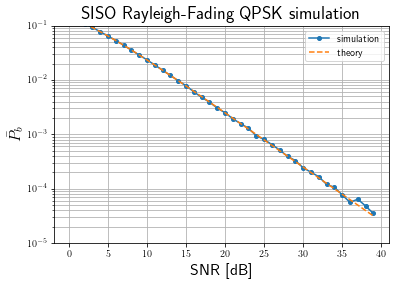

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import comm as comm
import copy
from scipy import special

plt.rcParams['text.usetex'] = True

#setting some parameters
n_symbols = 5e5
format_transmission = "PSK"
order = 4
Nr = 1

#generating some placeholders
snr_list = np.arange(0,40)
EsNo = 10**(snr_list/10)*np.log2(order) #skalierung von SNR auf SNR pro Symbol
EbNo = EsNo/np.log2(order) #skalierung von SNR pro Symbol auf SNR pro Bit
ber_res = np.ones(snr_list.shape)

for k in range(len(snr_list)):
    
    #generating signal object
    sig_tx = comm.signal.Signal(n_dims=Nr)
    sig_tx.generate_bits(n_bits=int(n_symbols*np.log2(order)),seed=None)
    sig_tx.generate_constellation(format=format_transmission, order=order)
    sig_tx.mapper()
    sig_tx.pulseshaper(upsampling=1, pulseshape="None") #we need this here, because of copying stuff in comm
    
    #### Channel ###################
    sig_ch = copy.deepcopy(sig_tx)
    
    #generate rayleigh channel coefficients
    psi_0 = 0 #ideal compensated phase 
    rayleigh_channel_coefficients = np.random.default_rng().rayleigh(size=len(sig_ch.samples[0]))*np.exp(1j*psi_0)
    #normalise raylight channel coefficients to 1
    #rayleigh_channel_coefficients = rayleigh_channel_coefficients*np.sqrt(1/np.mean(np.abs(rayleigh_channel_coefficients)**2))
    
    #apply rayleigh fading channel to samples
    sig_ch.samples[0] = sig_ch.samples[0] * rayleigh_channel_coefficients
    
    #add noise to signal
    sig_ch.samples[0] = comm.channel.set_snr(sig_ch.samples[0], snr_dB=10*np.log10(EsNo[k]))
    
    #compensate the rayleigh fading channel ideal
    sig_ch.samples[0] = sig_ch.samples[0] * np.conj(rayleigh_channel_coefficients)
    
    sig_rx = copy.deepcopy(sig_ch)

    sig_rx.decision()
    sig_rx.demapper()
    
    ber_res[k] = comm.rx.count_errors(sig_rx.bits[0], sig_rx.samples[0])["ber"]

ray_theory_qpsk = 1/2 * (1-np.sqrt((EbNo)/(1+EbNo))) 

plt.title("SISO Rayleigh-Fading QPSK simulation", fontsize=18)
plt.semilogy(snr_list, ber_res, marker="o", markersize=4, label="simulation")
plt.semilogy(snr_list, ray_theory_qpsk, ls="--", label="theory")
plt.xlabel("SNR [dB]", fontsize=16)
plt.ylabel(r"$$\bar{P}_b$$", fontsize=16)
plt.legend()
plt.ylim(1e-5,1e-1)
plt.grid(visible=True, which="both")
plt.show()

_______
Nachdem die SISO-Kanäle grundsätzlich untersucht wurden, sollen nun tiefere Untersuchungen mit räumlicher Diversität zum Funkkanal erfolgen. Hierfür wird ein **SIMO-System mit Rayleigh-Fading** genauer untersucht. Die Unterschiede zum bereits untersuchten SISO System liegen darin, dass nun mehere Funkkanäle quasi parrallel betrieben werden. Die Empfangssignale, in Abhängigkeit der Empfangsantenne $l$, wobei $l \in {0,...,L-1}$ (mit L als Gesamtzahl der Diversitäts-Antennen) können definiert werden als

\begin{equation}
\tag{15.3.1}
r_l(iT) = h_l \cdot d(i) + n_l(iT)
\end{equation}

wobei $h_l$ hierbei (nur) die komplexen Kanal-Bewertungsfaktoren darstellt. Kammeyer beschreibt hierbei auch die Einbeziehung von Sende- und Empfangsfilter, welches aber hier vernachlässig werden soll. Die Darstellungen $n_l(iT)$ sind Musterfunktionen für unabhägige Rauschprozesse. Die Auslegung eines Mehrantennen-Systems erzeugt die Notwendigkeit einer Kombinationsmethodik, wobei in diesem Fall das **MRC-Combining** untersucht werden soll. Das MRC-Combining hat zum Ziel, eine Linearkombiation der Empfangssignale zu bilden, welche ein maximales SNR ergibt. Die zugehörigen Kombinationskoeffizienten $c_l$ können nach einiger Umstellungen (-> Schwarzschen Ungleichung) mit 

\begin{equation}
\tag{15.3.4}
c_l = h_l^*
\end{equation}

für ein maximales SNR gewählt werden. Auch hierbei wird also eine ideale Kompensierung des Kanals, ähnlich der SISO-Variante, angestrebt. Die theoretische Herleitung für die ergodische Bitfehlerwarscheinlichkeit findet sich auf den Seiten 572ff. und schließt mit der Formel

\begin{equation}
\tag{15.3.10}
\bar{P_b}^{L-Ray} = 2K \left ( \frac{1-\alpha}{2} \right )^L \cdot \sum_{l=0}^{L-1} \binom{L-1+l}{l} \left( \frac{1+\alpha}{2} \right )^l
\text{ mit } 
\alpha = \sqrt{\frac{\frac{1}{L}\gamma^2\bar{E_b}/N_0}{1+\frac{1}{L}\gamma^2\bar{E_b}/N_0}}
\end{equation}

welche angibt, wie sich die Bitfehlerwarscheinlichkeit unter Berücksichtigung eines SIMO-Systems bei idealem MRC-combining verhält. Wichtig ist hierbei zu beachten, dass sowohl diese Formel, als auch die Darstellung im Beispiel über $\bar{E_b}{N_0}$ berechnet wird. Hierbei bezeichnet $\bar{E_b}$ die mittlere am Empfänger zur Verfügung stehende Gesamtenergie. Aus dem Wissen der vorherigen Betrachtung mit dem Zusammenhang zum SNR lässt sich simulativ erkennen, dass somit das SNR nach Kombination der Einzelsignale $\bar{E_b}{N_0}$ entspricht. Es ist deshalb in der Simulation zu berücksichtigen, dass pro Einzelkanal nur ein SNR von $SNR_{Pfad} = \frac{SNR_{gesamt}}{L} = \frac{\bar{E_b}{N_0}}{L}$ zu erzeugen ist. Formal lässt sich dieses mithilfe der Gleichung nach [Creasey](https://books.google.de/books/about/Advanced_Signal_Processing.html?id=iszN4Ohe1b0C&redir_esc=y) erklären

\begin{equation}
\tag{20, Seite 44, Creasey}
\gamma_{R} = \sum_{l=1}^L \gamma_{k}
\end{equation}

wobei $\gamma_{R}$ das resultiernde SNR und $\gamma_{k}$ das SNR des jeweiligen Pfades beschreibt. Die Formel sagt hierbei aus, dass ein ideal kombiniertes MRC Signal als resultierendes und kombiniertes SNR immer die Summe der "Einzelpfad"-SNRs ergeben muss. 

TODO:
- <span style="color:green"> Graphen von dieser Simulation (+= Kammeyer) und Rice-Kanal mit K=0 in MKS sind nicht gleich. Checken! </span>


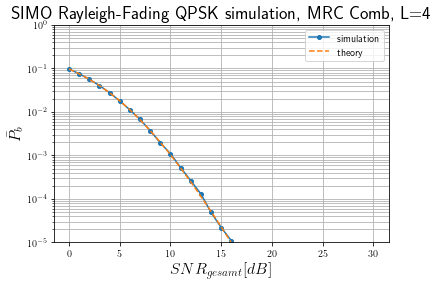

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import comm as comm
import copy
from scipy import special
plt.rcParams['text.usetex'] = True

#setting some parameters
n_symbols = 5e5
format_transmission = "PSK"
order = 4
L = 4

#generating some placeholders
snr_list = np.arange(0,31)
EsNo = 10**(snr_list/10)*np.log2(order) #skalierung von SNR auf SNR pro Symbol
EbNo = EsNo/np.log2(order) #skalierung von SNR pro Symbol auf SNR pro Bit
ber_res = np.ones(snr_list.shape)
snr_comb = np.zeros(snr_list.shape)
snr_single_antenna = np.zeros((L,len(snr_list)))

#generating signal object
sig_tx = comm.signal.Signal(n_dims=L)
sig_tx.generate_bits(n_bits=int(n_symbols*np.log2(order)),seed=None)
sig_tx.generate_constellation(format=format_transmission, order=order)
sig_tx.mapper()
sig_tx.pulseshaper(upsampling=1, pulseshape="None") #we need this here, because of copying stuff in comm

ref_sig = sig_tx.samples[0]
sig_tx.samples[0] =  sig_tx.samples[0] * (1 / np.mean(np.abs(sig_tx.samples[0])**2))  

for k in range(len(snr_list)):
    #### Channel ###################
    sig_ch = copy.deepcopy(sig_tx)
    
    #generate multiple paths
    for l in range(L):
        sig_ch.samples[l] = sig_ch.samples[0]
    
    #generate rayleigh channel coefficients
    psi_0 = 0 #ideal compensated phase 
    rayleigh_channel_coefficients = np.zeros((len(sig_ch.samples),len(sig_ch.samples[0])),dtype=complex)
    for l in range(L):
        rayleigh_channel_coefficients[l,:] = np.random.default_rng().rayleigh(size=len(sig_ch.samples[0]))*np.exp(1j*psi_0)
        rayleigh_channel_coefficients[l,:] = rayleigh_channel_coefficients[l,:]*np.sqrt((1/L)/np.mean(np.abs(rayleigh_channel_coefficients[l,:])**2))
    
    #apply rayleigh fading channel to samples
    for l in range(L):
        sig_ch.samples[l] = sig_ch.samples[l] * rayleigh_channel_coefficients[l,:]
        
    # adding noise
    for l in range(L):
        sig_ch.samples[l] = comm.channel.set_snr(sig_ch.samples[l], snr_dB=10*np.log10(EsNo[k]/L))
    
    sig_rx = copy.deepcopy(sig_ch)
    sig_rx.samples[0] = np.zeros(len(sig_ch.samples[0]), dtype=complex)
    
    #compensate the rayleigh fading channel ideal
    for l in range(L):
        sig_rx.samples[0] += sig_ch.samples[l] * np.conj(rayleigh_channel_coefficients[l,:])
    
    sig_rx.decision()
    sig_rx.demapper()
    
    ber_res[k] = comm.rx.count_errors(sig_rx.bits[0], sig_rx.samples[0])["ber"]
    
#generating rayleigh SIMO theory
gamma2 = 1
K = 1/2
alpha = np.sqrt(((1/L)*gamma2*EbNo)/(1+(1/L)*gamma2*EbNo))
sum_term = 0
for l in range(0,L):
    sum_term += special.binom(L-1+l,l)*((1+alpha)/2)**l
ray_theory_qpsk_div = 2*K*((1-alpha)/2)**L*sum_term

plt.title("SIMO Rayleigh-Fading QPSK simulation, MRC Comb, L={}".format(L), fontsize=18)
plt.semilogy(snr_list, ber_res, marker="o", markersize=4, label="simulation")
plt.semilogy(snr_list, ray_theory_qpsk_div, ls="--", label="theory")
plt.xlabel(r"$$SNR_{gesamt} [dB]$$", fontsize=16)
plt.ylabel(r"$$\bar{P_b}$$", fontsize=16)
plt.legend()
plt.ylim(1e-5,1)
plt.grid(visible=True, which="both")
plt.show()

_______
Aus dem Wissen der vorherigen Simulationen soll nun untersucht werden, ob sowohl MRC als auch EGC sich verhalten wie erwartet. Hierfür wird innerhalb eines AWGN-Kanals das SNR der Einzelkanänle und des kombinierten Kanals betrachtet, da diese Größe nicht von eventuellen Rx-DSP-Eigenschaften anders als die BER abhängig ist. Es ist somit auch für die nähere Zukunft interessant, diesen Parameter als Bezugs- und Kontrollgröße zu wählen. 
Nehmen wir an, wir haben einen AWGN-Kanal vorliegen. Bei diesem lässt sich das empfangene Signal $r$ beschreiben durch

\begin{equation}
\tag{--}
r = \alpha \cdot s + n
\end{equation}

wobei $\alpha$ den Kanalkoeffizienten darstellt. Wie beim AWGN-Kanal üblich, nehmen wir für den Rauschprozess eine Standard-Normalverteilung ($\mu = 0, \sigma_N^2 = 1$) an. Mit dem Wissen, dass das SNR definiert werden kann als Quadratamplitude durch Varianz des Rauschprozesses, lässt sich der Kanalkoeffizient hierraus mithilfe von

\begin{equation}
\tag{--}
SNR = \frac{A^2}{\sigma^2} = \frac{a^2}{\sigma^2_N} = \frac{a^2}{1}
\end{equation}

bestimmen. Wie dargestellt, ergibt sich somit für den Fall eines AWGN-Kanals ein Kanalkoeffizient von $\alpha = \sqrt{SNR}$. Mithilfe dieser Darstellung ist es uns möglich, nun weitere Kombinationsverfahren hinsichtlich des Verhaltens des SNRs zu untersuchen. Betrachten wir zuerst die teilweise bereits bekannten Gleichungen für die eigentliche Umsetzung der Kombinationsverfahren:

\begin{equation}
\tag{--, (Angelehnt an (18), Seite 44, Creasey)}
r_{MRC} = \sum_{l=1}^L \alpha_l \cdot r_l
\end{equation}

\begin{equation}
\tag{--, (Angelehnt an (?), Seite 45, Creasey)}
r_{EGC} = \sum_{l=1}^L r_l
\end{equation}

diese zeigen, dass nur für die Umsetzung von MRC die Kanalkoeffizienten benötigt werden. Bei EGC werden diese Kanalkoeffizienten als 1 angenommen, wir gehen deshalb davon aus, dass jedes (Teil-)Signal mit dem gleichen Gain beaufschlagt wird. Um einen Wert zu ermitteln, mit die korrekte Funktion der Kombinierung verfizieren können, werden theoretische erwartbare Werte benötigt. Diese sind gegeben als

\begin{equation}
\tag{20, Seite 44, Creasey}
\gamma_{R} = \sum_{l=1}^L \gamma_{k}
\end{equation}

\begin{equation}
\tag{--?, vermutlich Nuszkowski}
\gamma_{R} = \frac{1}{L} \cdot \left( \sum_{l=1}^L |\alpha_l| \right )^2
\end{equation}

und beschreiben das erwartbare SNR des kombinierten Signals in Abhängikeit des SNRs der Einzelkanäle.


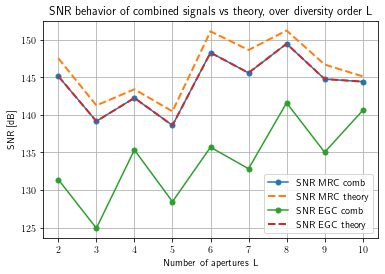

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import comm as comm
import copy
from scipy import special

plt.rcParams['text.usetex'] = True

#setting some parameters
n_symbols = 5e5
format_transmission = "PSK"
order = 4

#generating some placeholders
n_dims_list = np.arange(2,11)
center_snr = 15 #dB

snr_mrc = np.zeros(len(n_dims_list))
snr_egc = np.zeros(len(n_dims_list))
theory_mrc = np.zeros(len(n_dims_list))
theory_egc = np.zeros(len(n_dims_list))
middle_snr = np.zeros(len(n_dims_list))

for k in range(len(n_dims_list)):
    L = n_dims_list[k]
    #snr_list_lin = np.random.default_rng().normal(loc=(10**(center_snr/10)), scale=10, size=L)
    #snr_list_lin = np.random.default_rng().uniform(low=(10**(5/10)),high=(10**(25/10)), size=L)
    snr_list_lin = np.random.default_rng().lognormal(mean=(10**(center_snr/10)), sigma=2, size=L)
    #snr_list_lin = np.random.default_rng().rayleigh(scale=(10**(center_snr/10))/(np.sqrt(np.pi/2)), size=L)

    #generating signal object
    sig_tx = comm.signal.Signal(n_dims=int(L))
    sig_tx.generate_bits(n_bits=int(n_symbols*np.log2(order)),seed=None)
    sig_tx.generate_constellation(format=format_transmission, order=order)
    sig_tx.mapper()
    sig_tx.pulseshaper(upsampling=1, pulseshape="None") #we need this here, because of copying stuff in comm

    sig_tx.samples[0] = sig_tx.samples[0]/np.sqrt(np.mean(np.abs(sig_tx.samples[0])**2))

    #### Channel ###################
    sig_ch = copy.deepcopy(sig_tx)

    for l in range(L):
        sig_ch.samples[l] = sig_tx.samples[0]

    for l in range(L):
        sig_ch.samples[l] = comm.channel.set_snr(sig_ch.samples[l], snr_dB=10*np.log10(snr_list_lin[l]))

    mrc_sig = np.zeros(len(sig_tx.samples[0]), dtype=complex)
    egc_sig = np.zeros(len(sig_tx.samples[0]), dtype=complex)

    for l in range(L):
        mrc_sig += sig_ch.samples[l] * np.sqrt(snr_list_lin[l])
        egc_sig += sig_ch.samples[l] * 1
    
    mrc_sig =  mrc_sig/np.sqrt(np.mean(np.abs(mrc_sig)**2))
    egc_sig =  egc_sig/np.sqrt(np.mean(np.abs(egc_sig)**2))

    snr_mrc[k] = 10*np.log10(np.var(sig_tx.samples[0])/np.var(mrc_sig-sig_tx.samples[0]))
    snr_egc[k] = 10*np.log10(np.var(sig_tx.samples[0])/np.var(egc_sig-sig_tx.samples[0]))

    theory_mrc[k] = 10*np.log10(np.sum(snr_list_lin))
    theory_egc[k] = 10*np.log10((1/L)*(np.sum([abs(np.sqrt(x)) for x in snr_list_lin])**2))

plt.figure()
plt.title("SNR behavior of combined signals vs theory, over diversity order L")
plt.plot(n_dims_list, snr_mrc, label="SNR MRC comb", marker="o", markersize=5)
plt.plot(n_dims_list, theory_mrc, label="SNR MRC theory", ls="--", lw=2)
plt.plot(n_dims_list, snr_egc, label="SNR EGC comb", marker="o", markersize=5)
plt.plot(n_dims_list, theory_egc, label="SNR EGC theory", ls="--", lw=2)
plt.grid(visible=True, which="both")
plt.legend()
plt.xlabel("Number of apertures L")
plt.ylabel("SNR [dB]")
plt.show()


______
Einen direkter Diversitätsgewinn (SNR des kombinierten Signals zu mittlerem SNR aller Einzelkanäle) lässt sich zumindest für das MRC-Verfahren direkt ableiten. [Nuszkowski](https://books.google.de/books/about/Digitale_Signalübertragung_im_Mobilfunk.html?id=S03poAEACAAJ&hl=en&output=html_text&redir_esc=y) nennt diese Darstellung des Verhätnisses von SNR und Kombinierung den sog. normierten Mittelwert (kombinierter SNR-Gewinn gegenüber dem SNR der Einzelkanäle). Wie für MRC bereis aus der Gleichung von Creasey ersichtlich, ist dieses im Falle von MRC einfach mit 

\begin{equation}
\tag{23, Seite 44, Creasey}
\ \bar{\gamma}_{R, MRC, Gewinn} = L
\end{equation}

zu beschreiben. Eine allgemeine Lösung für EGC ist hierbei nicht möglich; allerdings lässt sich für die Annahme von _Rayleigh-verteilten Kanalkoeffizieten_ eine Gleichung in Creasey finden:

\begin{equation}
\tag{25, Seite 45, Creasey}
\ \bar{\gamma}_{R, EGC, Gewinn} = \left[  1 + (L -1) \frac{\pi}{4} \right] 
\end{equation}

Während der Diversitätsgewinn für das MRC Verfahren unabhängig der Verteilung der Kanalkoeffizienten ist, gilt dieses nicht für EGC. Der Nachweis dieser Gleichungen soll in folgender Simulation erfolgen. Hinweis: Genauere Herleitungen und Betrachtungen zur EGC Problematik lassen sich sehr verständlich bei [Brennan, 1959](https://ieeexplore.ieee.org/document/4065786) finden.

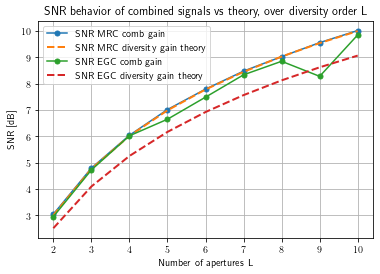

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import comm as comm
import copy
from scipy import special

plt.rcParams['text.usetex'] = True

#setting some parameters
n_symbols = 5e5
format_transmission = "PSK"
order = 4

#generating some placeholders
n_dims_list = np.arange(2,11)
center_snr = 15 #dB

snr_mrc = np.zeros(len(n_dims_list))
snr_egc = np.zeros(len(n_dims_list))
theory_mrc_dg = np.zeros(len(n_dims_list))
theory_egc_dg = np.zeros(len(n_dims_list))
middle_snr = np.zeros(len(n_dims_list))

for k in range(len(n_dims_list)):
    L = n_dims_list[k]
    #snr_list_lin = np.random.default_rng().normal(loc=(10**(center_snr/10)), scale=10, size=L)
    #snr_list_lin = np.random.default_rng().uniform(low=(10**(5/10)),high=(10**(25/10)), size=L)
    #snr_list_lin = np.random.default_rng().lognormal(mean=(10**(center_snr/10)), sigma=2, size=L)
    snr_list_lin = np.random.default_rng().rayleigh(scale=(10**(center_snr/10))/(np.sqrt(np.pi/2)), size=L)

    #generating signal object
    sig_tx = comm.signal.Signal(n_dims=int(L))
    sig_tx.generate_bits(n_bits=int(n_symbols*np.log2(order)),seed=None)
    sig_tx.generate_constellation(format=format_transmission, order=order)
    sig_tx.mapper()
    sig_tx.pulseshaper(upsampling=1, pulseshape="None") #we need this here, because of copying stuff in comm

    sig_tx.samples[0] = sig_tx.samples[0]/np.sqrt(np.mean(np.abs(sig_tx.samples[0])**2))

    #### Channel ###################
    sig_ch = copy.deepcopy(sig_tx)

    for l in range(L):
        sig_ch.samples[l] = sig_tx.samples[0]

    for l in range(L):
        sig_ch.samples[l] = np.sqrt(snr_list_lin[l])*sig_ch.samples[l]+np.random.default_rng().standard_normal(size=sig_ch.samples[l].size)

    mrc_sig = np.zeros(len(sig_tx.samples[0]), dtype=complex)
    egc_sig = np.zeros(len(sig_tx.samples[0]), dtype=complex)

    for l in range(L):
        mrc_sig += sig_ch.samples[l] * np.sqrt(snr_list_lin[l])
        egc_sig += sig_ch.samples[l] * 1
    
    mrc_sig =  mrc_sig/np.sqrt(np.mean(np.abs(mrc_sig)**2))
    egc_sig =  egc_sig/np.sqrt(np.mean(np.abs(egc_sig)**2))

    snr_mrc[k] = 10*np.log10(np.var(sig_tx.samples[0])/np.var(mrc_sig-sig_tx.samples[0]))
    snr_egc[k] = 10*np.log10(np.var(sig_tx.samples[0])/np.var(egc_sig-sig_tx.samples[0]))

    middle_snr[k] = 10*np.log10(np.mean(snr_list_lin))

    theory_mrc_dg[k] = 10*np.log10(L) #diversity gain
    theory_egc_dg[k] = 10*np.log10(1+(L-1)*np.pi/4) #diversity gain

plt.figure()
plt.title("SNR behavior of combined signals vs theory, over diversity order L")
plt.plot(n_dims_list, snr_mrc-middle_snr, label="SNR MRC comb gain", marker="o", markersize=5)
plt.plot(n_dims_list, theory_mrc_dg, label="SNR MRC diversity gain theory", ls="--", lw=2)
plt.plot(n_dims_list, snr_egc-middle_snr, label="SNR EGC comb gain", marker="o", markersize=5)
plt.plot(n_dims_list, theory_egc_dg, label="SNR EGC diversity gain theory", ls="--", lw=2)
#plt.plot(n_dims_list, middle_snr, label="mean SNR of apertures", ls="", color="gray", marker="*", markersize=4)
plt.grid(visible=True, which="both")
plt.legend()
plt.xlabel("Number of apertures L")
plt.ylabel("SNR [dB]")
plt.show()


_____
Bei der vorangegangenen Simulation wird deutlich, dass die simulierten Werte von EGC und die beschriebene Theorie nicht oder nur unzureichend über den betrachteten Raum von Empfänger-Diversität aufeinander passen. Dieses liegt nicht zuletzt daran, dass nur ein Durchlauf betrachtet wurde, und in diesem Fall somit keine Mittelung über verschiedene (Rayleigh-)verteilte Werte vorgenommen wurde. Dieses muss in folgender Simulation nachgeholt werden. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import comm as comm
import copy
from scipy import special

plt.rcParams['text.usetex'] = True

#setting some parameters
n_symbols = 5e5
format_transmission = "PSK"
order = 4
MC_runs = 1000

#generating some placeholders
n_dims_list = np.arange(2,11)
center_snr = 15 #dB

snr_mrc = np.zeros((MC_runs,len(n_dims_list)))
snr_egc = np.zeros((MC_runs,len(n_dims_list)))
theory_mrc_dg = np.zeros((MC_runs,len(n_dims_list)))
theory_egc_dg = np.zeros((MC_runs,len(n_dims_list)))
middle_snr = np.zeros((MC_runs,len(n_dims_list)))

for j in range(MC_runs):
    for k in range(len(n_dims_list)):
        L = n_dims_list[k]
        #snr_list_lin = np.random.default_rng().normal(loc=(10**(center_snr/10)), scale=10, size=L)
        #snr_list_lin = np.random.default_rng().uniform(low=(10**(5/10)),high=(10**(25/10)), size=L)
        #snr_list_lin = np.random.default_rng().lognormal(mean=(10**(center_snr/10)), sigma=2, size=L)
        snr_list_lin = np.random.default_rng().rayleigh(scale=(10**(center_snr/10))/(np.sqrt(np.pi/2)), size=L)

        #generating signal object
        sig_tx = comm.signal.Signal(n_dims=int(L))
        sig_tx.generate_bits(n_bits=int(n_symbols*np.log2(order)),seed=None)
        sig_tx.generate_constellation(format=format_transmission, order=order)
        sig_tx.mapper()
        sig_tx.pulseshaper(upsampling=1, pulseshape="None") #we need this here, because of copying stuff in comm

        sig_tx.samples[0] = sig_tx.samples[0]/np.sqrt(np.mean(np.abs(sig_tx.samples[0])**2))

        #### Channel ###################
        sig_ch = copy.deepcopy(sig_tx)

        for l in range(L):
            sig_ch.samples[l] = sig_tx.samples[0]

        for l in range(L):
            sig_ch.samples[l] = np.sqrt(snr_list_lin[l])*sig_ch.samples[l]+np.random.default_rng().standard_normal(size=sig_ch.samples[l].size)

        mrc_sig = np.zeros(len(sig_tx.samples[0]), dtype=complex)
        egc_sig = np.zeros(len(sig_tx.samples[0]), dtype=complex)

        for l in range(L):
            mrc_sig += sig_ch.samples[l] * np.sqrt(snr_list_lin[l])
            egc_sig += sig_ch.samples[l] * 1

        mrc_sig =  mrc_sig/np.sqrt(np.mean(np.abs(mrc_sig)**2))
        egc_sig =  egc_sig/np.sqrt(np.mean(np.abs(egc_sig)**2))

        snr_mrc[j,k] = 10*np.log10(np.var(sig_tx.samples[0])/np.var(mrc_sig-sig_tx.samples[0]))
        snr_egc[j,k] = 10*np.log10(np.var(sig_tx.samples[0])/np.var(egc_sig-sig_tx.samples[0]))

        middle_snr[j,k] = 10*np.log10(np.mean(snr_list_lin))

        theory_mrc_dg[j,k] = 10*np.log10(L) #diversity gain
        theory_egc_dg[j,k] = 10*np.log10(1+(L-1)*np.pi/4) #diversity gain

plt.figure()
plt.title("SNR behavior of combined signals vs theory, over diversity order L")
plt.plot(n_dims_list, snr_mrc-middle_snr, label="SNR MRC comb gain", marker="o", markersize=5)
plt.plot(n_dims_list, theory_mrc_dg, label="SNR MRC diversity gain theory", ls="--", lw=2)
plt.plot(n_dims_list, snr_egc-middle_snr, label="SNR EGC comb gain", marker="o", markersize=5)
plt.plot(n_dims_list, theory_egc_dg, label="SNR EGC diversity gain theory", ls="--", lw=2)
#plt.plot(n_dims_list, middle_snr, label="mean SNR of apertures", ls="", color="gray", marker="*", markersize=4)
plt.legend()
plt.xlabel("Number of apertures L")
plt.ylabel("SNR [dB]")
plt.show()
